In [1]:
#Set up path
# import sys
# #sys.path.append('/ye/yelabstore3/guy_mm/DoubletDetection/src/doubletdetection')
# sys.path.append('/netapp/home/emccarthy/miniconda3/lib/python3.6/site-packages')
# sys.path.append('/netapp/home/emccarthy/miniconda3/bin')
# sys.path.append('/netapp/home/emccarthy/miniconda3/lib')
# sys.path.append('/netapp/home/emccarthy/miniconda3/x86_64-conda_cos6-linux-gnu/sysroot/lib')

# sys.path.append('/netapp/home/emccarthy/miniconda3/envs/scanpy/bin')
#Import libraries
import time
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.sparse import csr_matrix
import logging
#from skbio.stats.composition import clr

#import doubletdetection
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#import os
#For CLR of ADTs
import scipy
import scipy.stats
from sklearn.preprocessing import scale
import os
import math

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.logging.print_versions() 
sc.settings.set_figure_params(dpi=100)

/wynton/home/kimlab/hyang7/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
sample_list = pd.read_csv('../metadata/10x_bladder_cancer_metadata_09092019_EM.csv', sep = ',')

sample_list

filename    sample       pop  \
0   161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_...    atezo2    atezo2   
1    170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD4    atezo3    atezo3   
2      170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T4    atezo4    atezo4   
3   170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/...    atezo5    atezo5   
4   170109_D00328_0602_AHFKK7BCXY_version_1.1_10xg...      soc1      soc1   
5                170207_D00328_0611_AHFMGHBCXY_10x/P3      soc2      soc2   
6    170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T4      soc3      soc3   
7    170124_D00328_0608_AHC5WNBCXY_10xgenomics/07NCD4  a3normal  a3normal   
8      170301_D00328_0619_AHFNFVBCXY_10xgenomics/08N4  a4normal  a4normal   
9   170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/...  a5normal  a5normal   
10  170109_D00328_0602_AHFKK7BCXY_version_1.1_10xg...  s1normal  s1normal   
11               170207_D00328_0611_AHFMGHBCXY_10x/P1  s2normal  s2normal   
12   170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N4  s3normal  s3normal   

   treatment  tissue patient comp  
0      atezo   tumor      a2  CD4  
1      atezo   tumor      a3  CD4  
2      atezo   tumor      a4  CD4  
3      atezo   tumor      a5  CD4  
4        soc   tumor      s1  CD4  
5        soc   tumor      s2  CD4  
6        soc   tumor      s3  CD4  
7      atezo  normal      a3  CD4  
8      atezo  normal      a4  CD4  
9      atezo  normal      a5  CD4  
10       soc  normal      s1  CD4  
11       soc  normal      s2  CD4  
12       soc  normal      s3  CD4

In [4]:
RNA_files = np.array(sample_list['filename'])
RNA_files

array(['161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD4',
       '170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD4',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T4',
       '170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD4',
       '170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1TCD4',
       '170207_D00328_0611_AHFMGHBCXY_10x/P3',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T4',
       '170124_D00328_0608_AHC5WNBCXY_10xgenomics/07NCD4',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/08N4',
       '170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12NCD4',
       '170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1NCD4',
       '170207_D00328_0611_AHFMGHBCXY_10x/P1',
       '170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N4'], dtype=object)

In [5]:
#Load 10x data
#Create directories where cache folder will live
#!mkdir /ye/yelabstore3/PCI/005_production/analysis
#!mkdir /ye/yelabstore3/PCI/005_production/analysis/preprocessing
#Set directory where cahce files will save
os.chdir("/wynton/group/fong/hyang7/bladder_blood_analysis/obj/")

#Update all these inputs
#START
no_wells = sample_list.shape[0]
RNA_files = sample_list['filename'].tolist()
#RNA_files = np.array(sample_list['sample'])
patient = np.array(sample_list['patient'])
tissue = np.array(sample_list['tissue'])
treatment = np.array(sample_list['treatment'])
sample = np.array(sample_list['sample'])
comp = np.array(sample_list['comp'])


RNA_path_prefix = "/ye/yelabstore2/bladder_cancer/10xdata_for_backup/"
RNA_path_suffix = "/outs/filtered_gene_bc_matrices/hg19/"
#END

#Initialize list to store adata objects
RNA_adata = [None] * no_wells


#Initialize dataframe to store cell counts
#height = 6
height = 1
width = no_wells
cell_count_df = pd.DataFrame(0, index=range(height), columns=range(width))
cell_count_df.rename(index={0:'Cells'}, inplace=True)
#Rename the columns
cell_count_df.columns = RNA_files


for i in range(no_wells):
    start = time.time()
    
    well = RNA_files[i]
    print(well)
    
    #Load RNA adata
    path = RNA_path_prefix + RNA_files[i] + RNA_path_suffix
#   RNA_adata[i] = sc.read_10x_mtx(path, var_names='gene_symbols', cache=True)
    RNA_adata[i] = sc.read_10x_mtx(path, var_names='gene_symbols', cache=False)
    print("Loaded RNA")
    
    
    
    print("Added singlet info")
    cell_count_df[well] = [RNA_adata[i].shape[0]]
    
    print("Add cell annotations")

    RNA_adata[i].obs['patient'] = [patient[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['tissue'] = [tissue[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['treatment'] = [treatment[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['sample'] = [sample[i]]*RNA_adata[i].shape[0]
    RNA_adata[i].obs['comp'] = [comp[i]]*RNA_adata[i].shape[0]
    
    end = time.time()
    print(end-start, "sec")


161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD4
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
5.23908805847168 sec
170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD4
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
4.672324180603027 sec
170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T4
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
3.938717842102051 sec
170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD4
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
Loaded RNA
Added singlet info
Add cell annotations
3.963291645050049 sec
170109_D00328_0602_AHFKK7BCXY_version_1.1_10xg

In [6]:
cell_count_df.T

Cells
161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_a...   2399
170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD4     2843
170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T4       3695
170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/1...   3721
170109_D00328_0602_AHFKK7BCXY_version_1.1_10xge...   1826
170207_D00328_0611_AHFMGHBCXY_10x/P3                 3378
170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T4     1117
170124_D00328_0608_AHC5WNBCXY_10xgenomics/07NCD4      462
170301_D00328_0619_AHFNFVBCXY_10xgenomics/08N4        775
170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/1...    383
170109_D00328_0602_AHFKK7BCXY_version_1.1_10xge...   1077
170207_D00328_0611_AHFMGHBCXY_10x/P1                  144
170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N4      422

161212_D00108_0622_BH7K3FBCXY_10xanalysis/new_analysis/05TCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


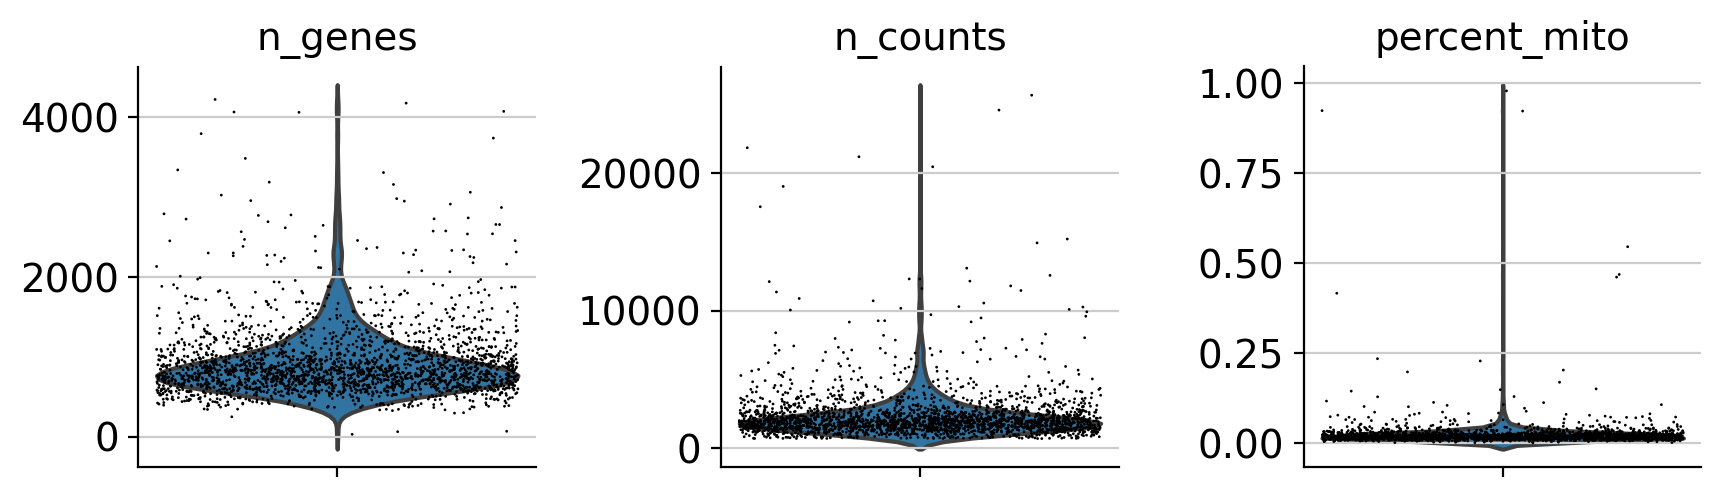

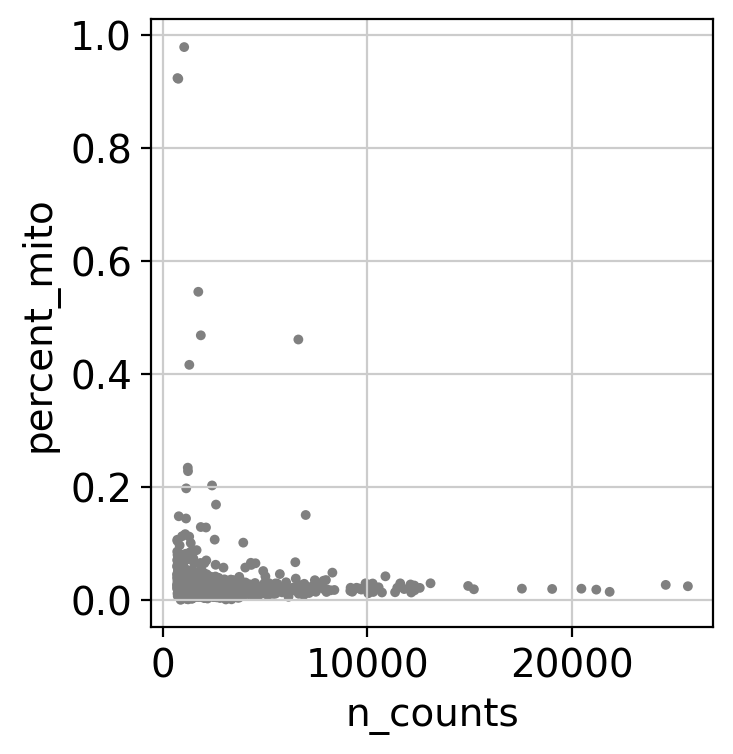

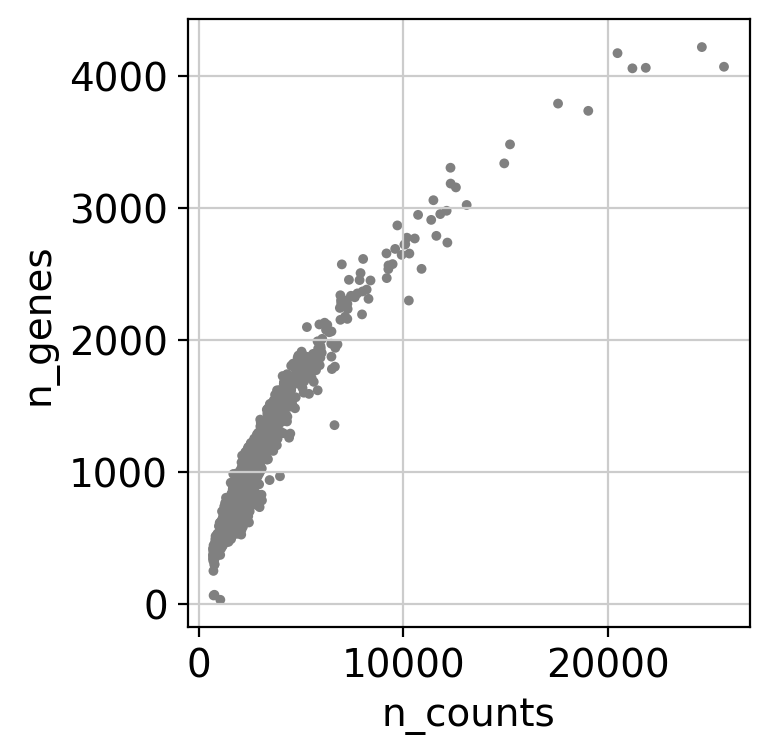

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170124_D00328_0608_AHC5WNBCXY_10xgenomics/07TCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


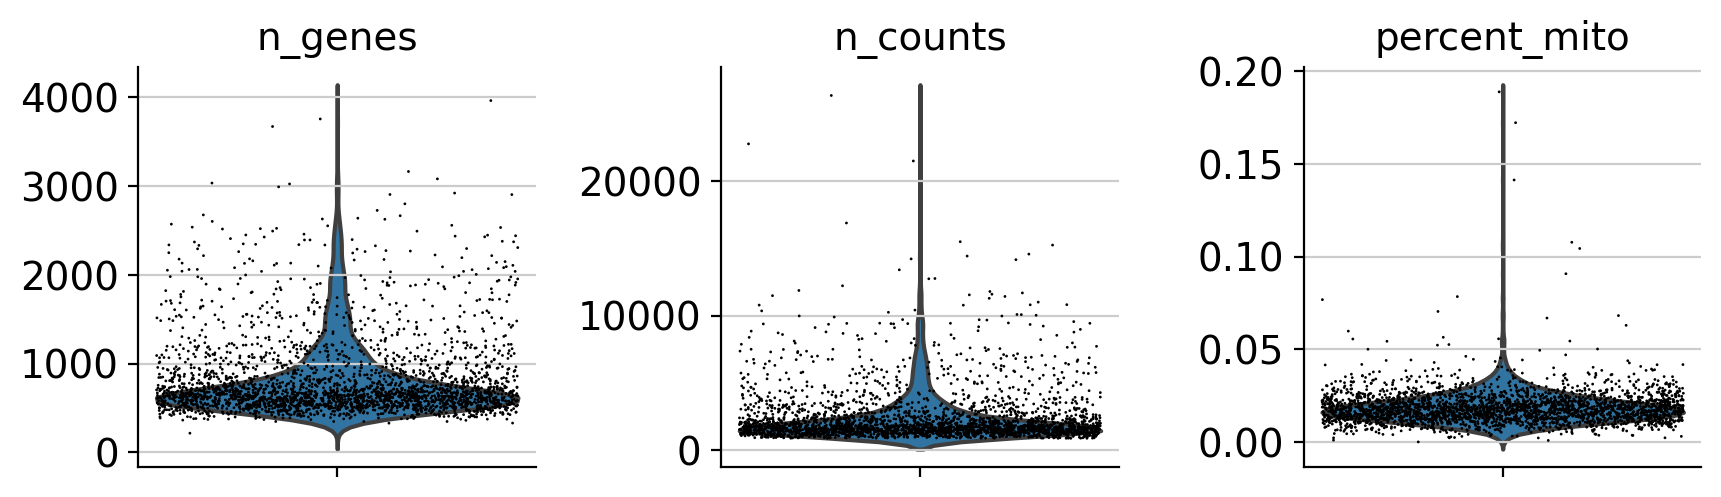

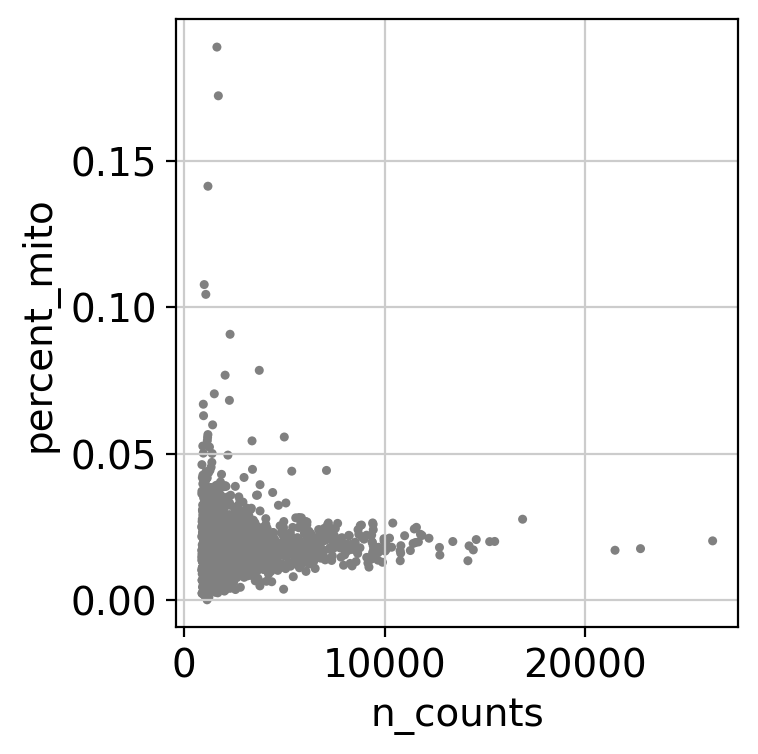

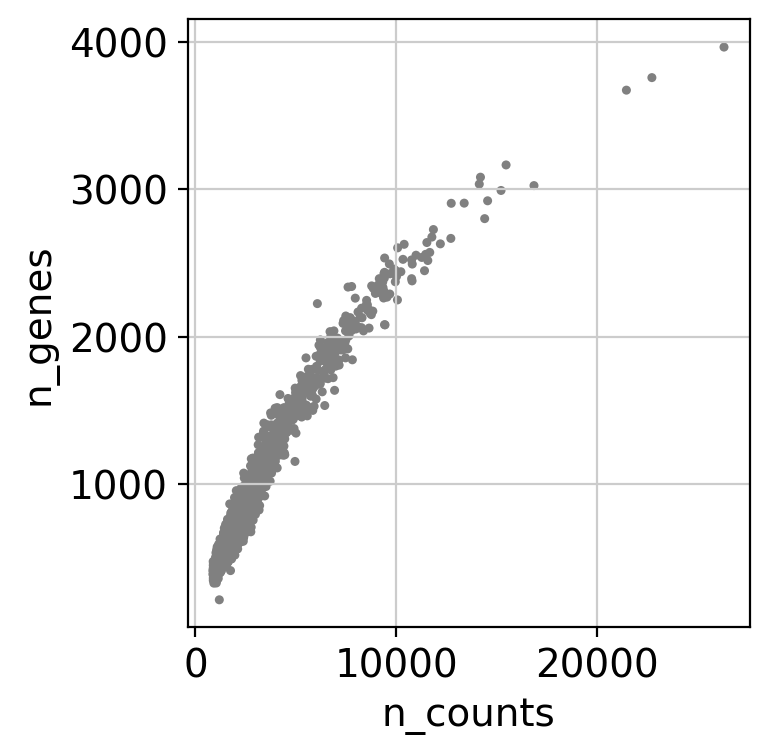

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/08T4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


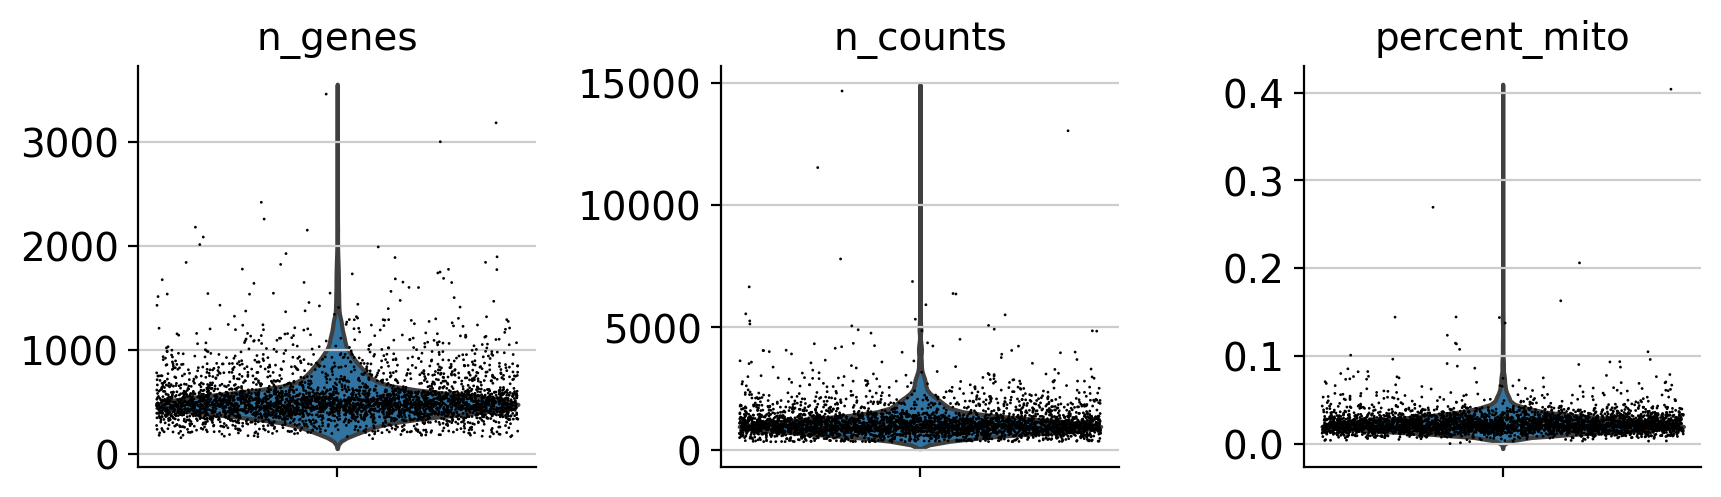

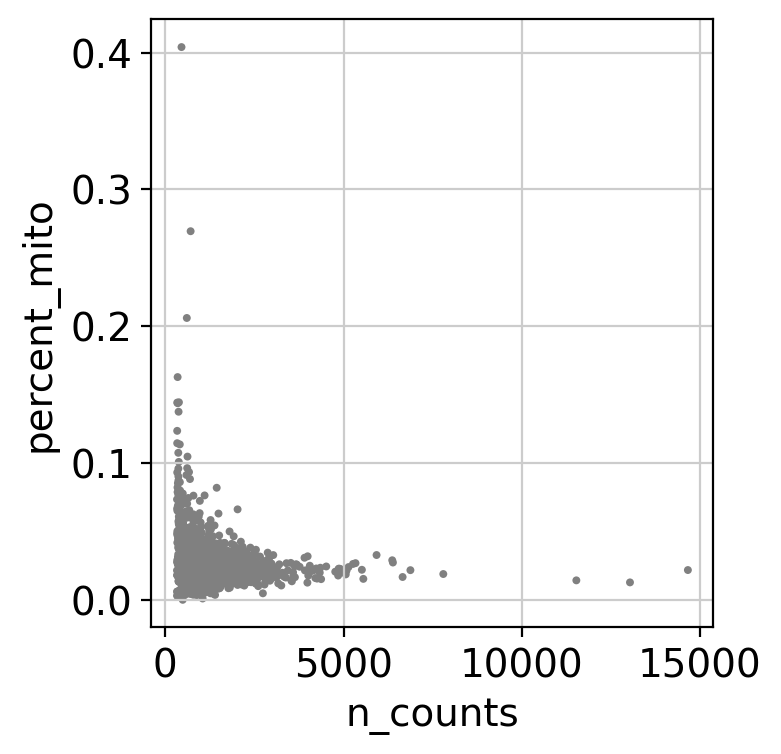

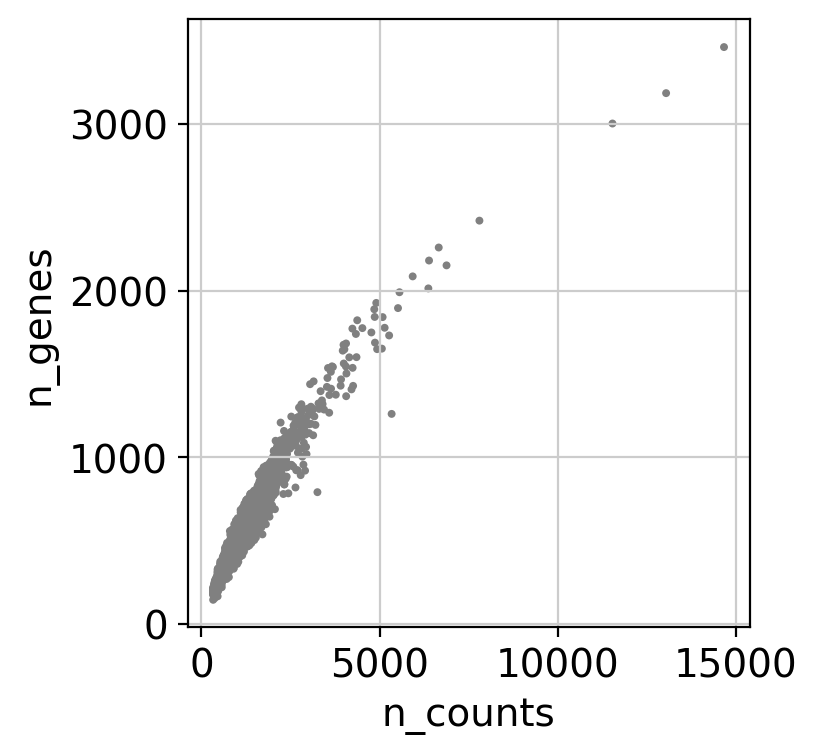

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12TCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


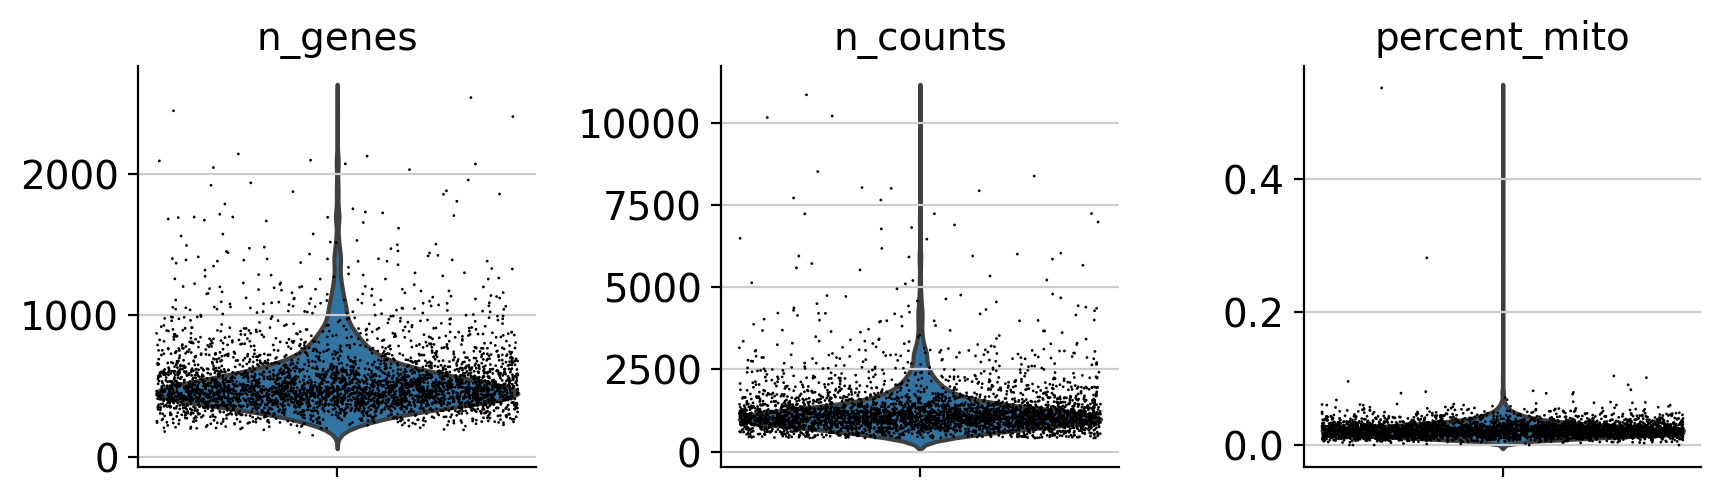

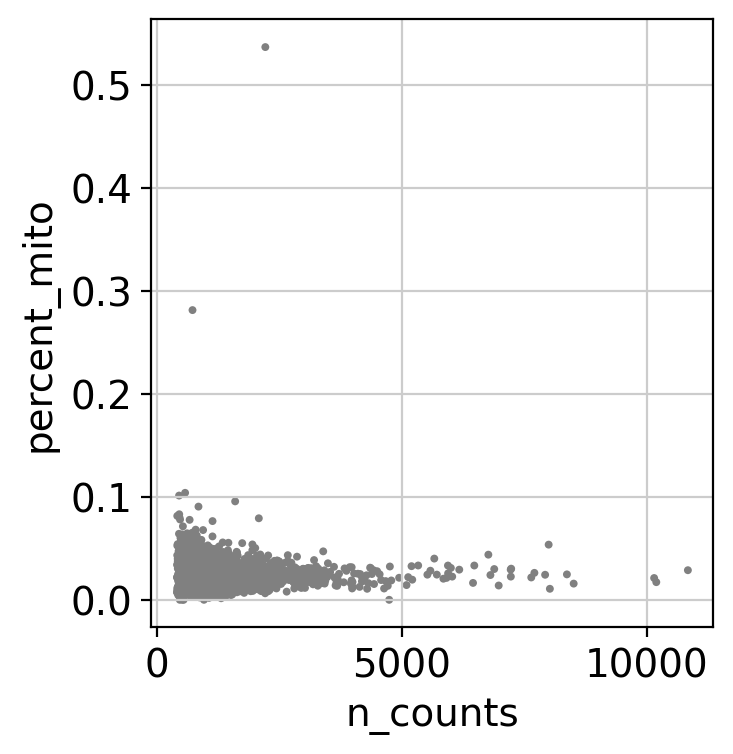

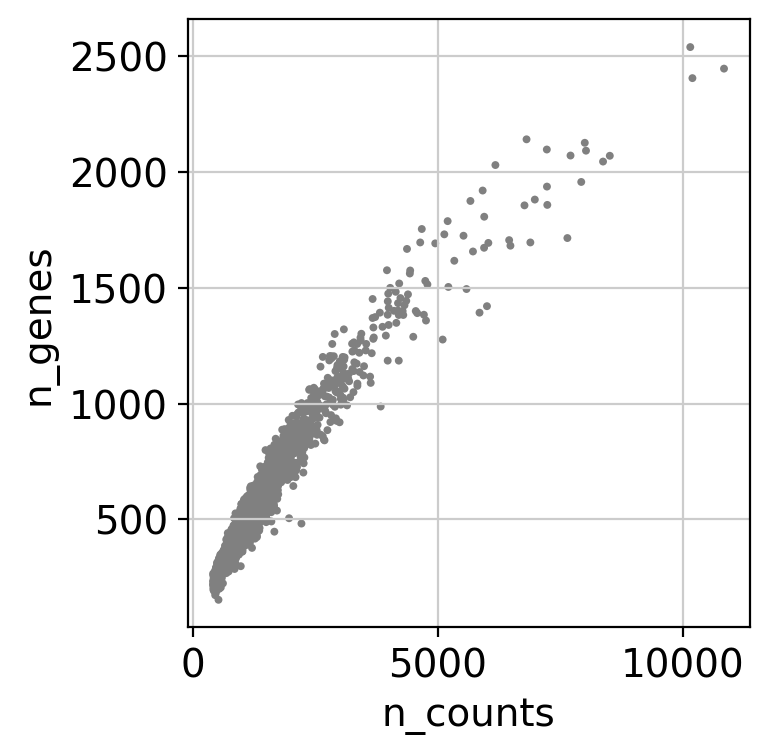

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1TCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


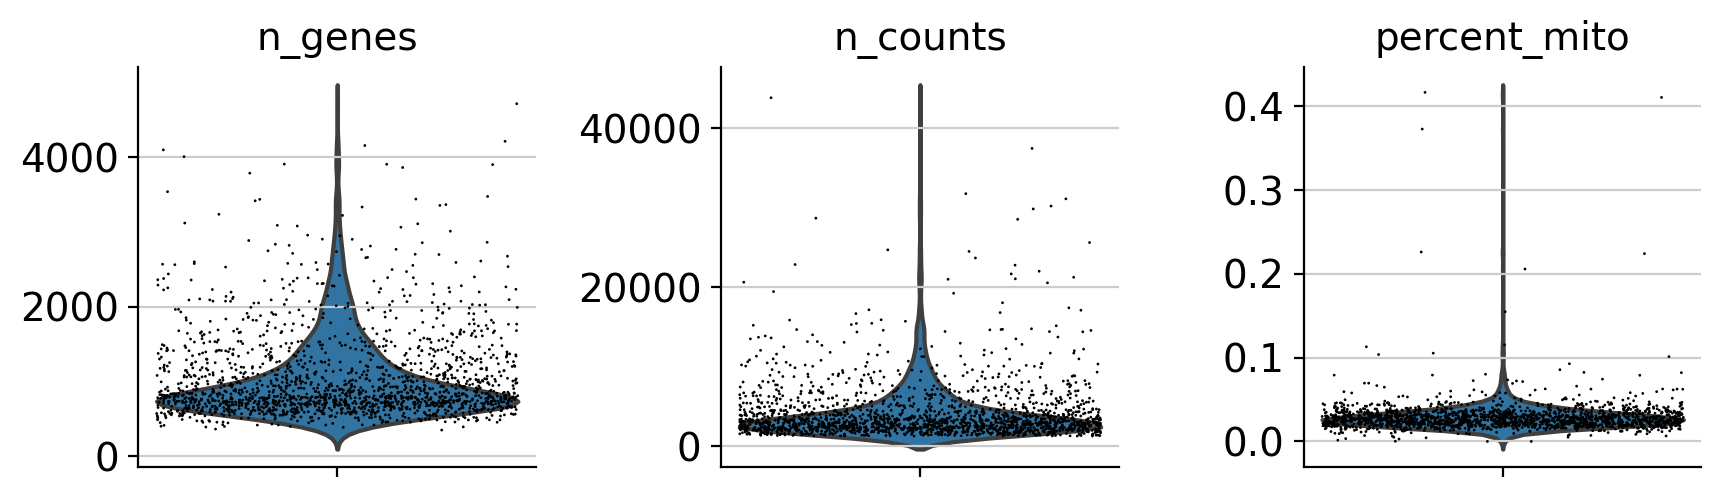

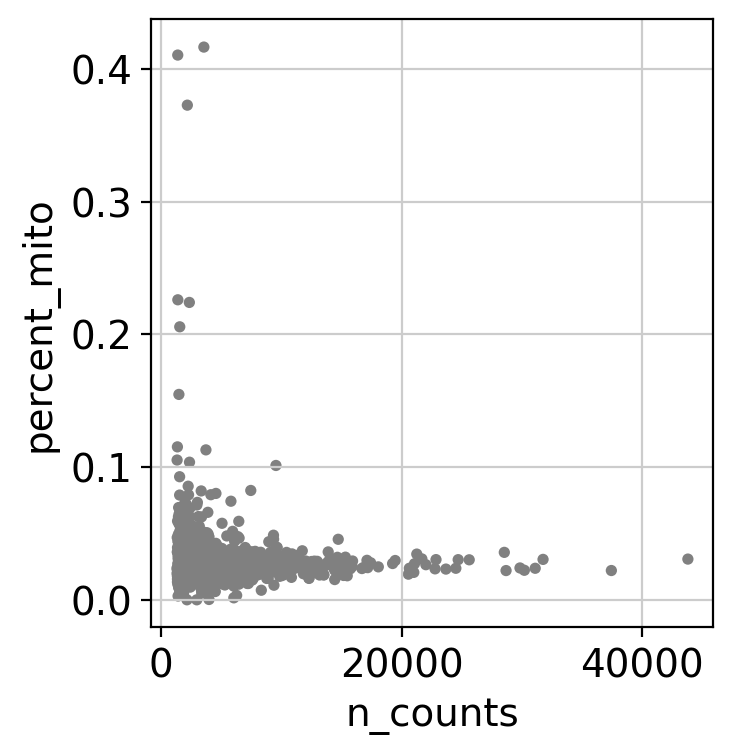

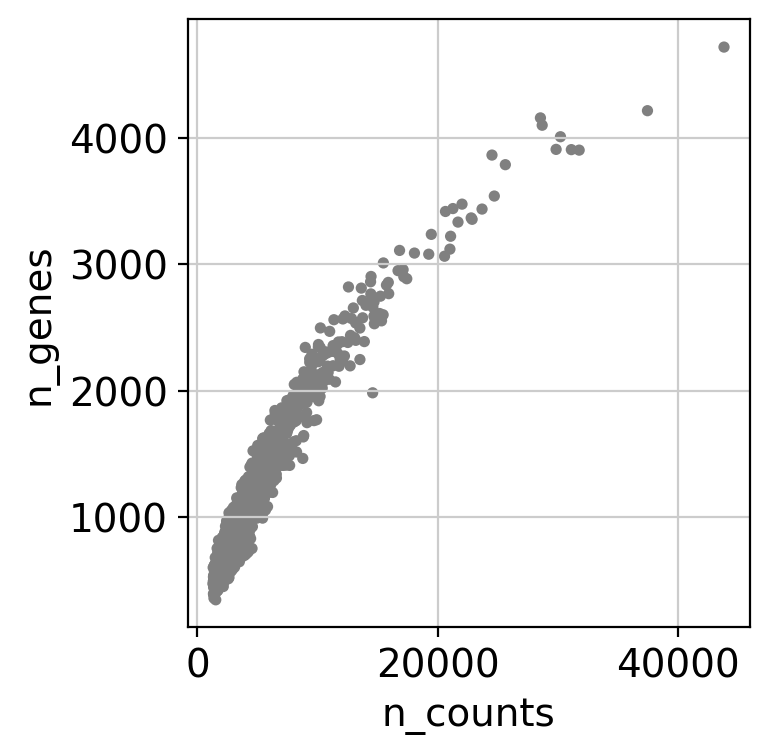

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170207_D00328_0611_AHFMGHBCXY_10x/P3
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


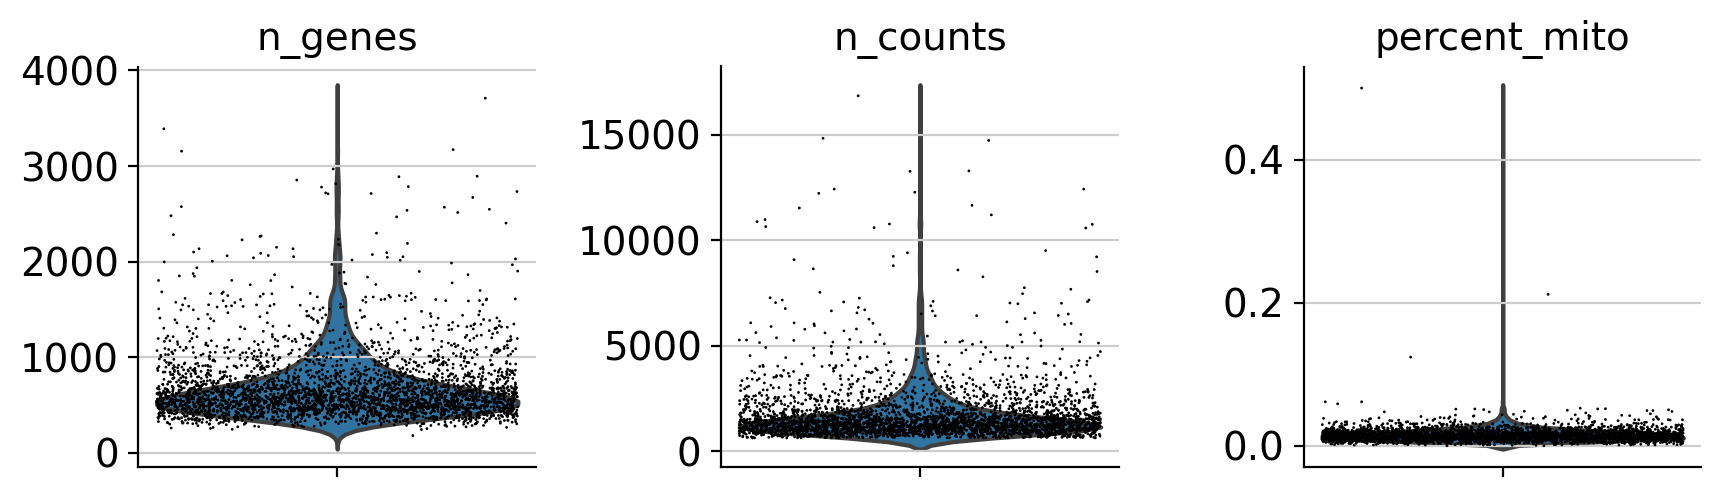

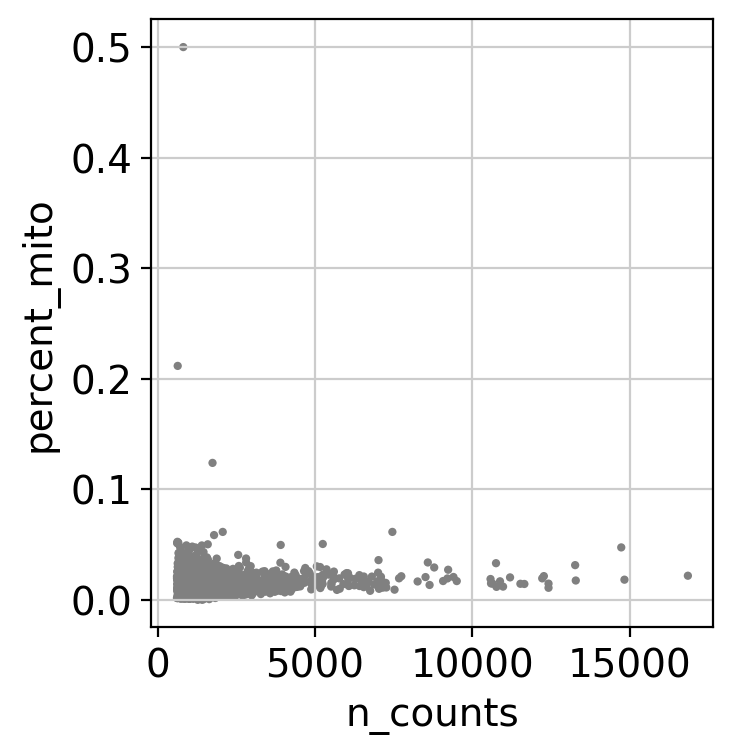

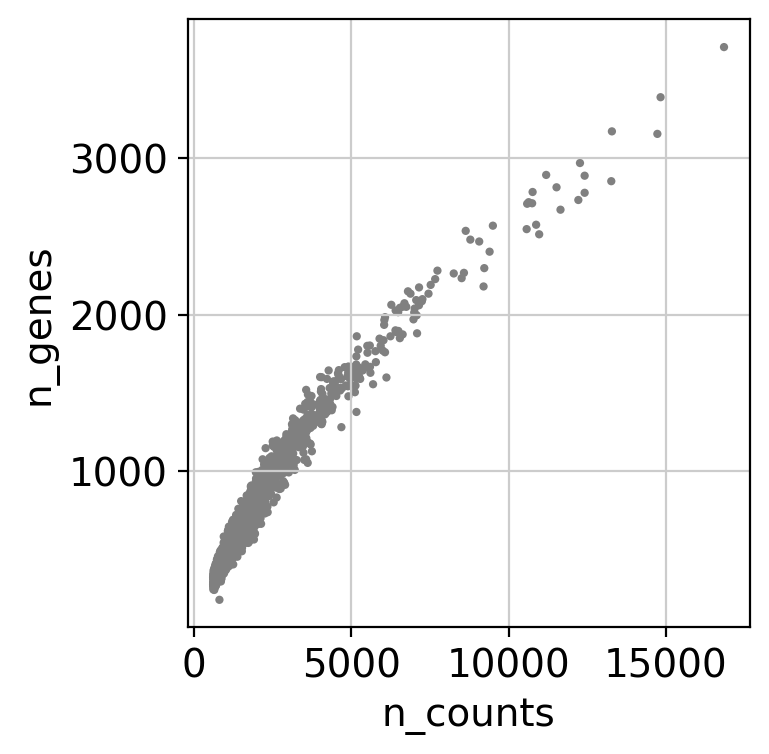

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4T4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


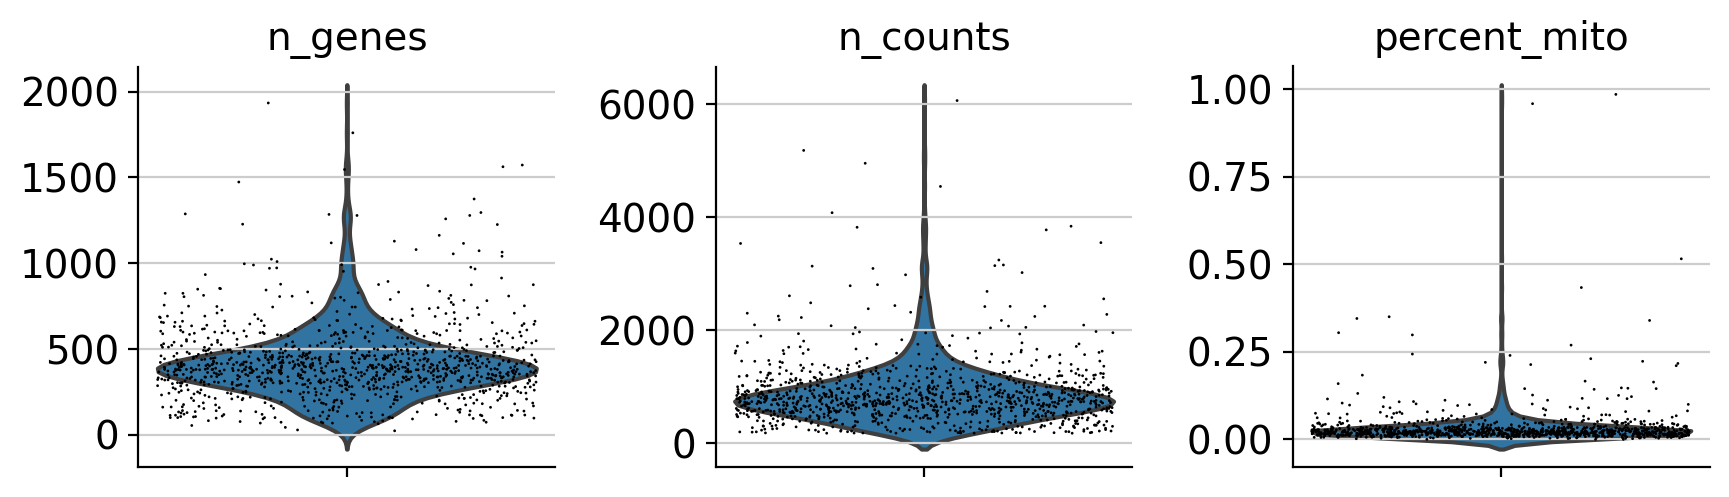

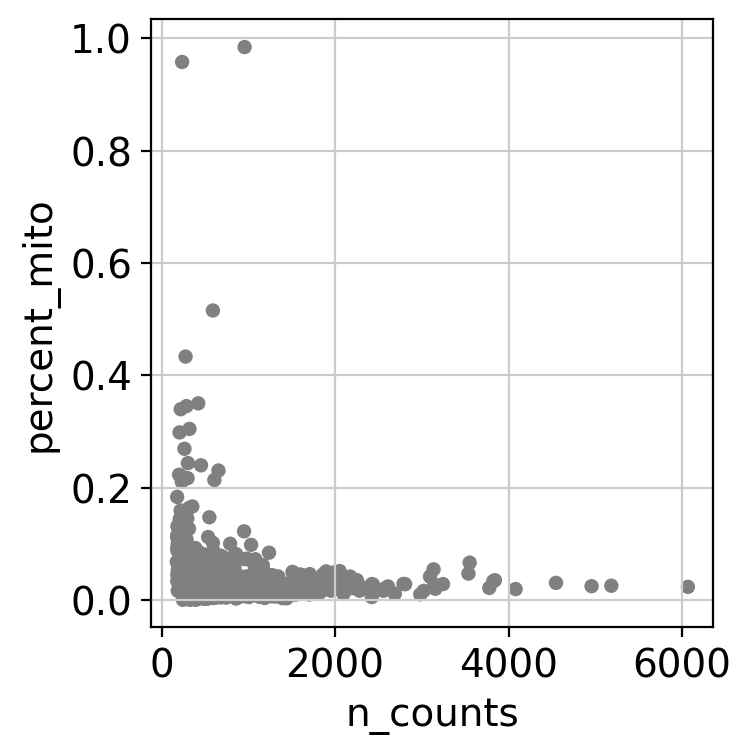

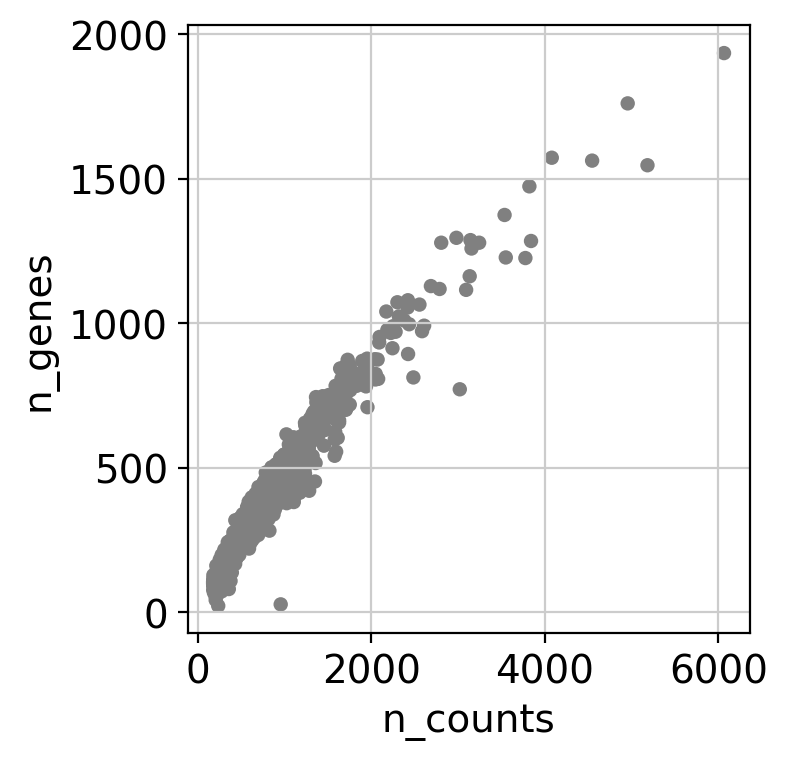

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170124_D00328_0608_AHC5WNBCXY_10xgenomics/07NCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


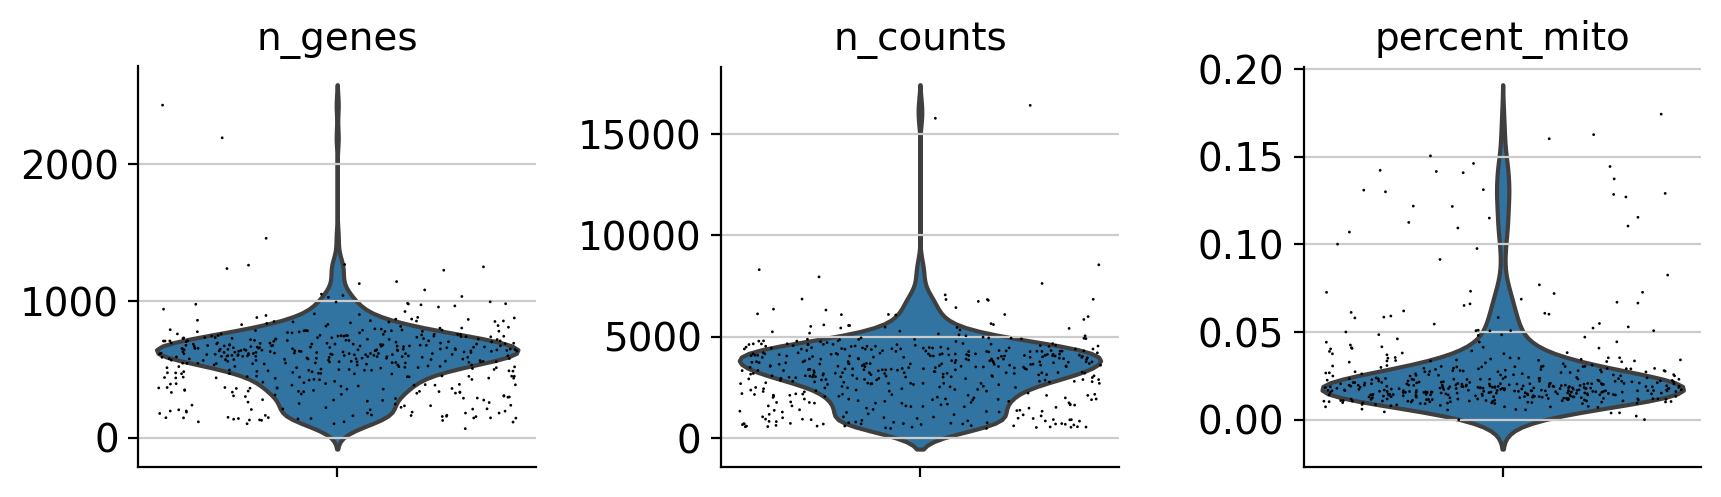

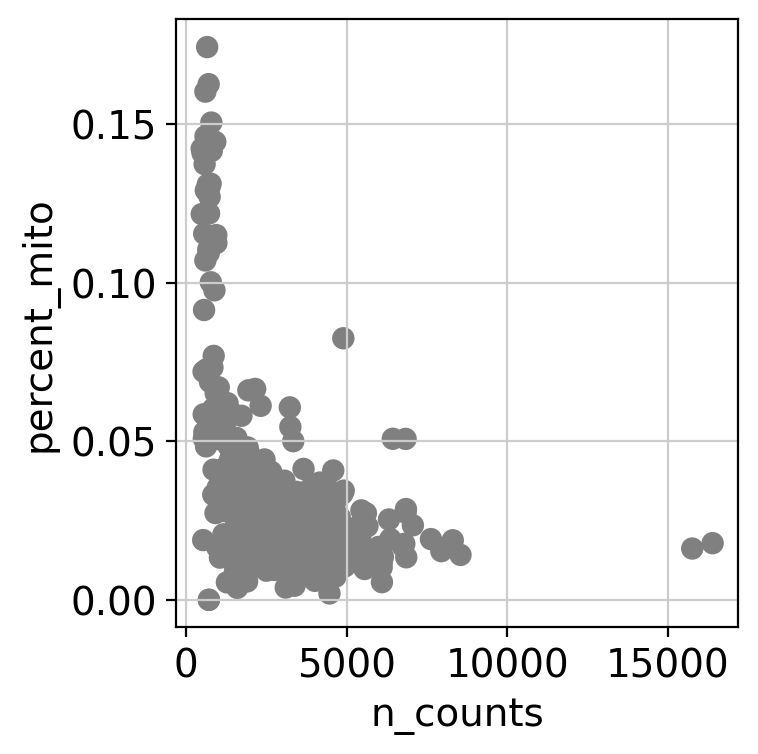

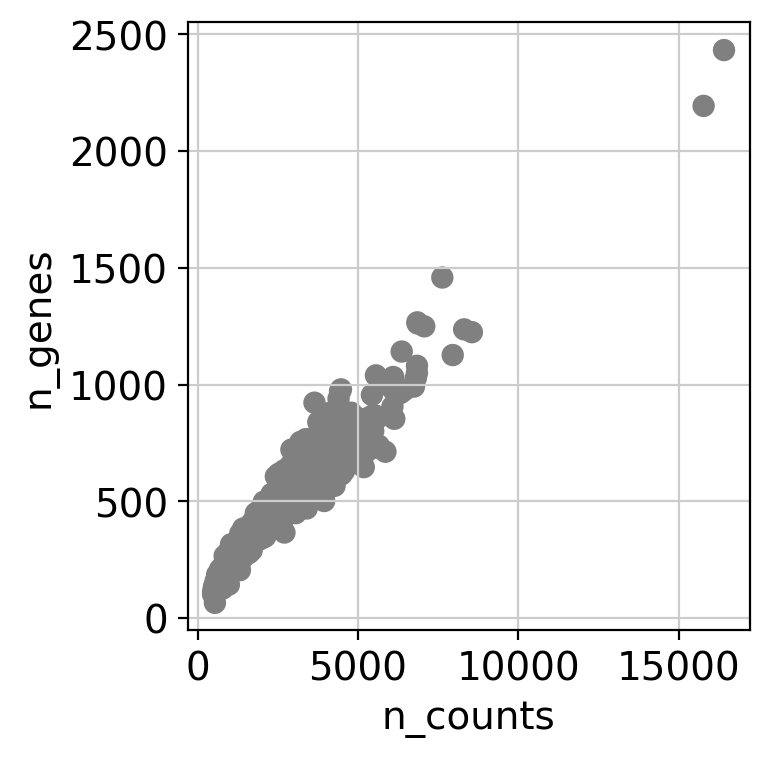

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/08N4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


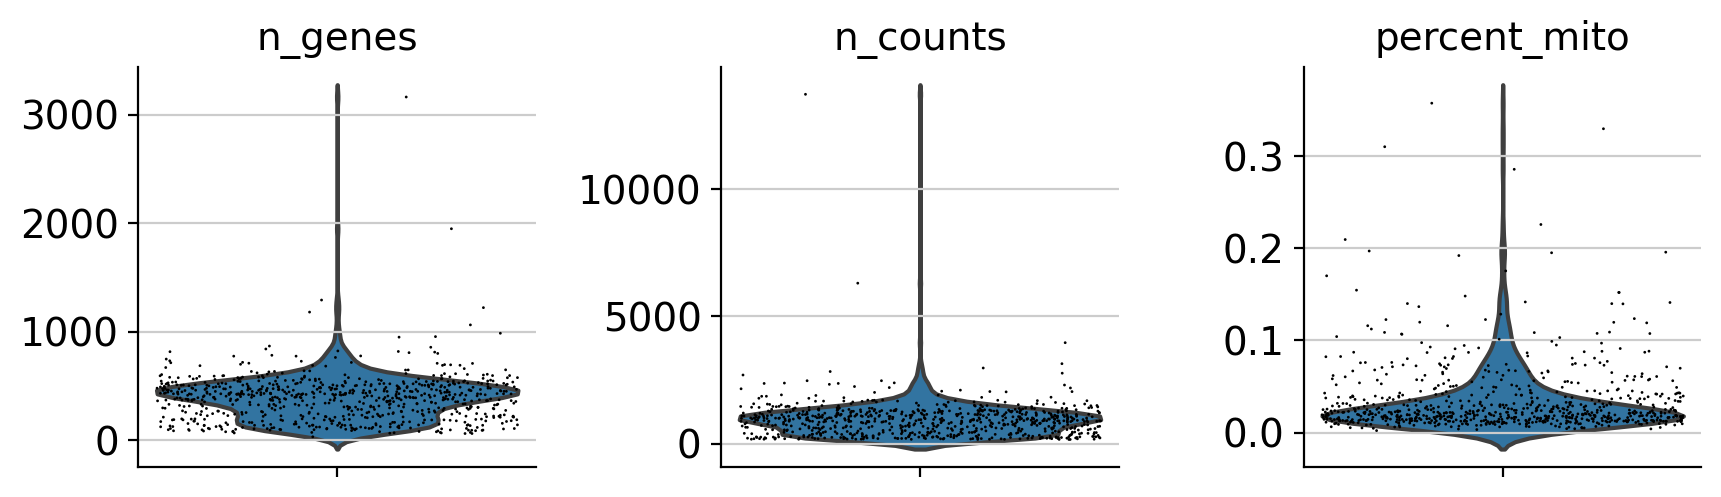

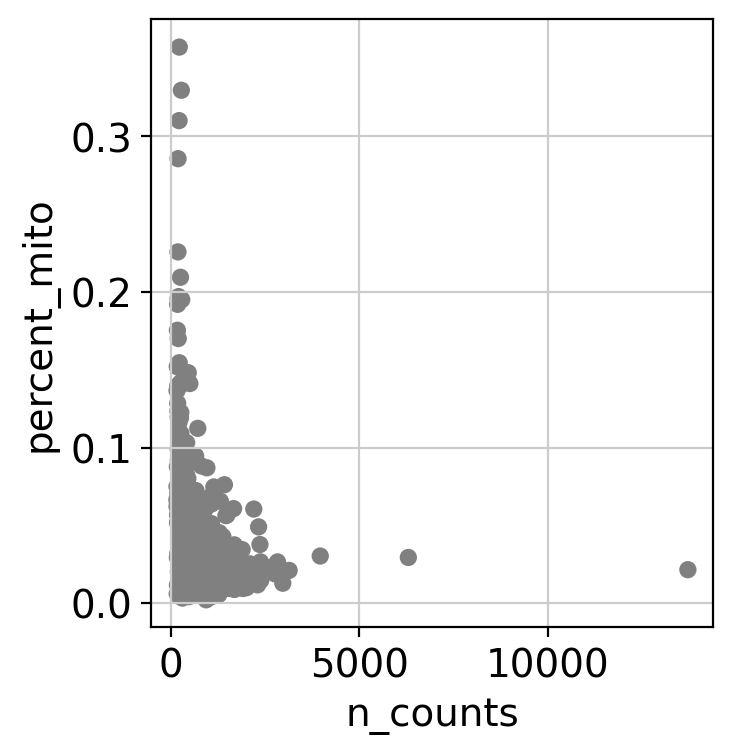

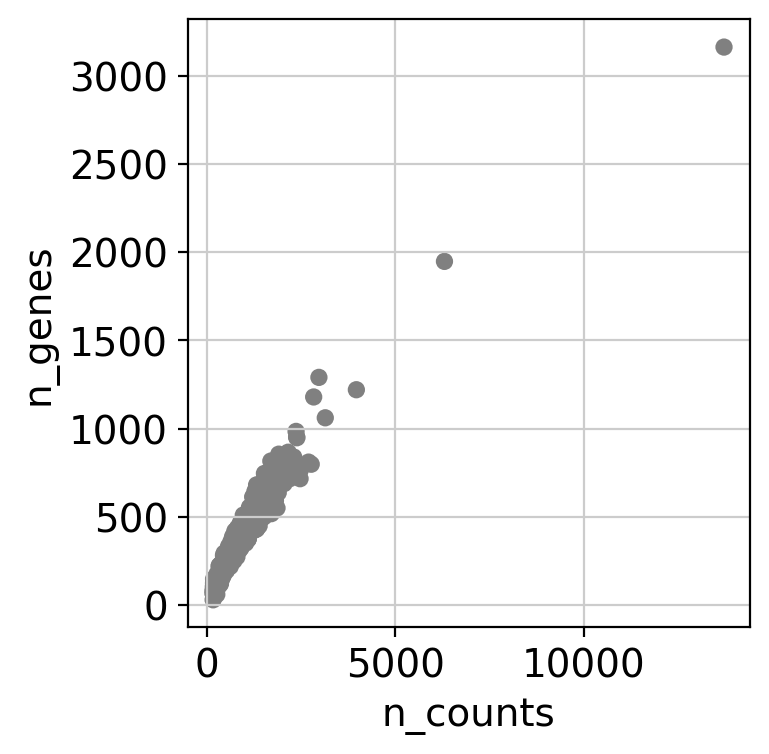

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170601_D00328_0660_BHM3FMBCXY_fastqs_analysis/12NCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


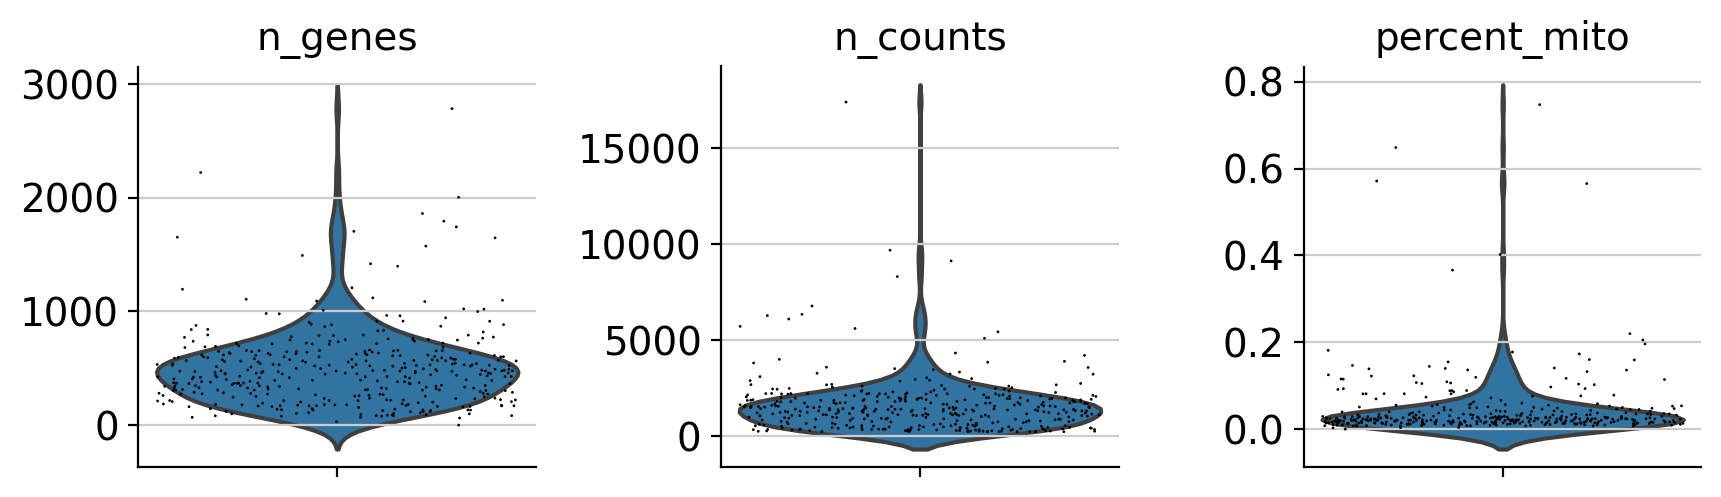

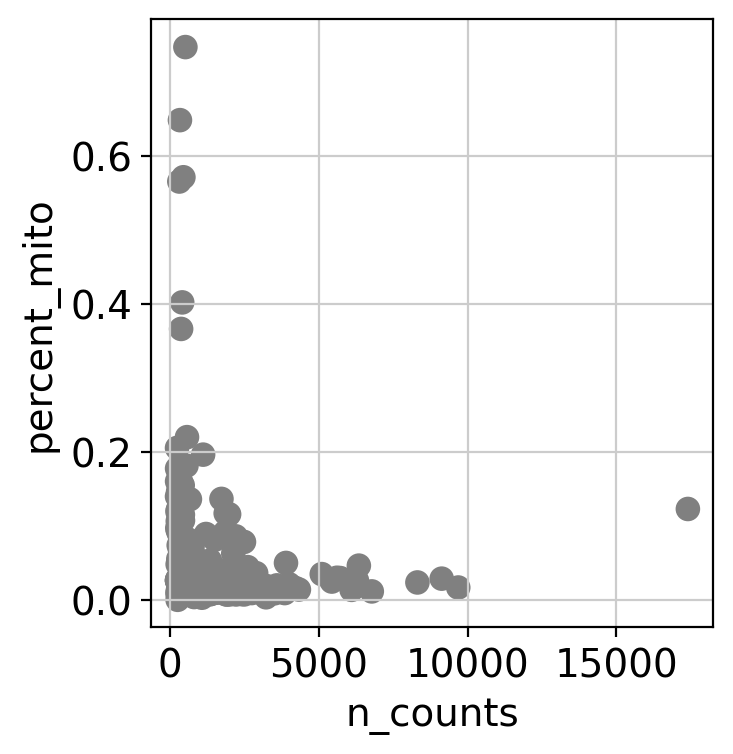

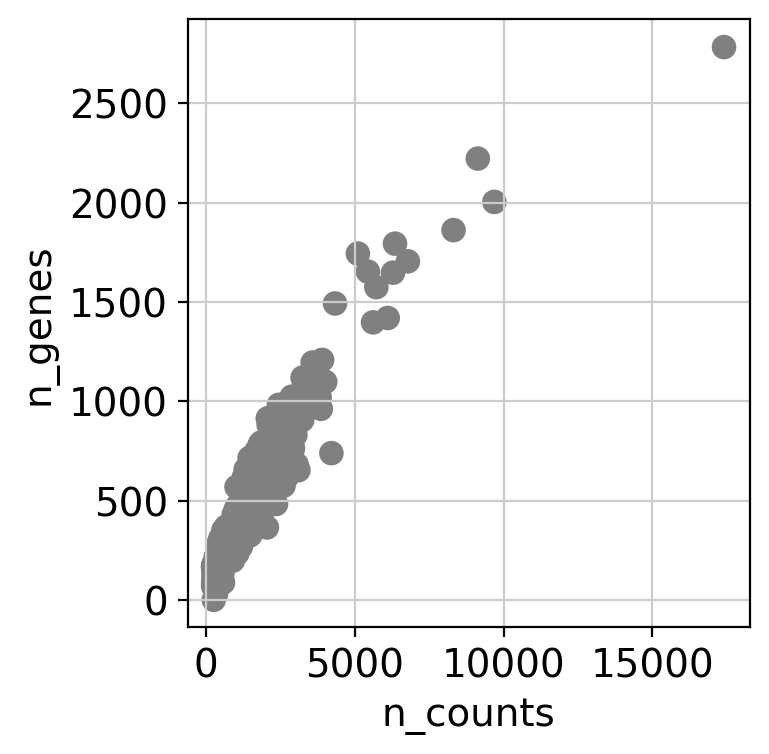

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170109_D00328_0602_AHFKK7BCXY_version_1.1_10xgenomics/SO1NCD4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


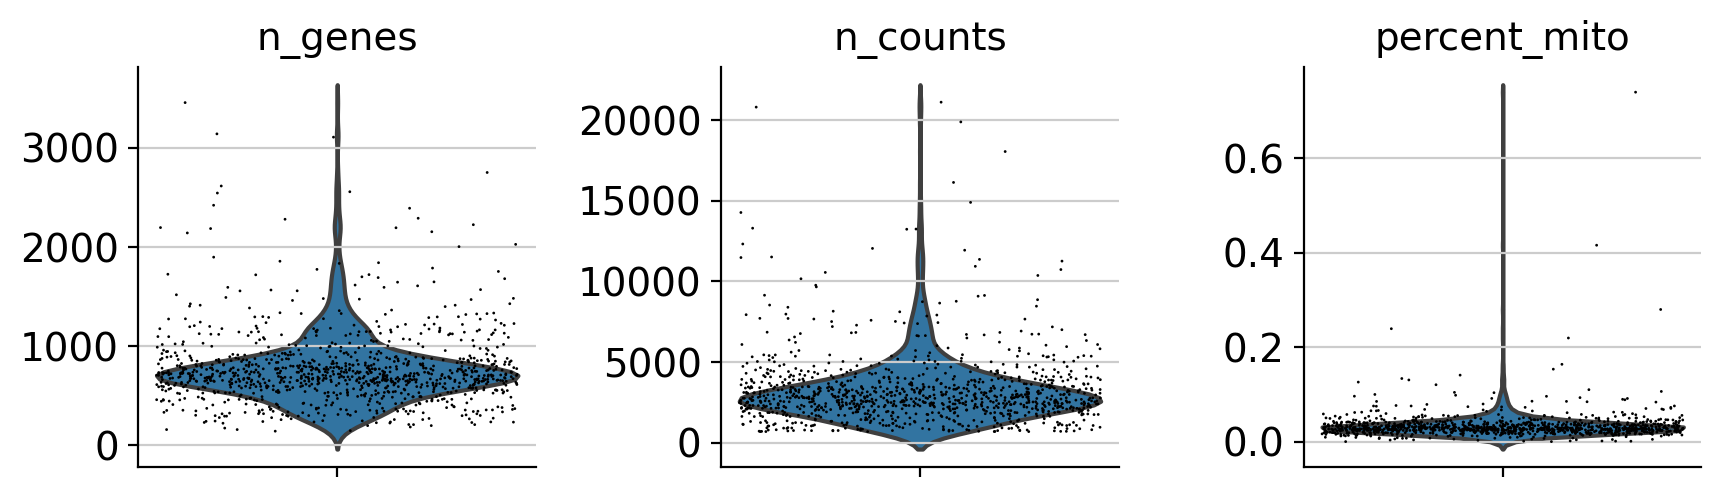

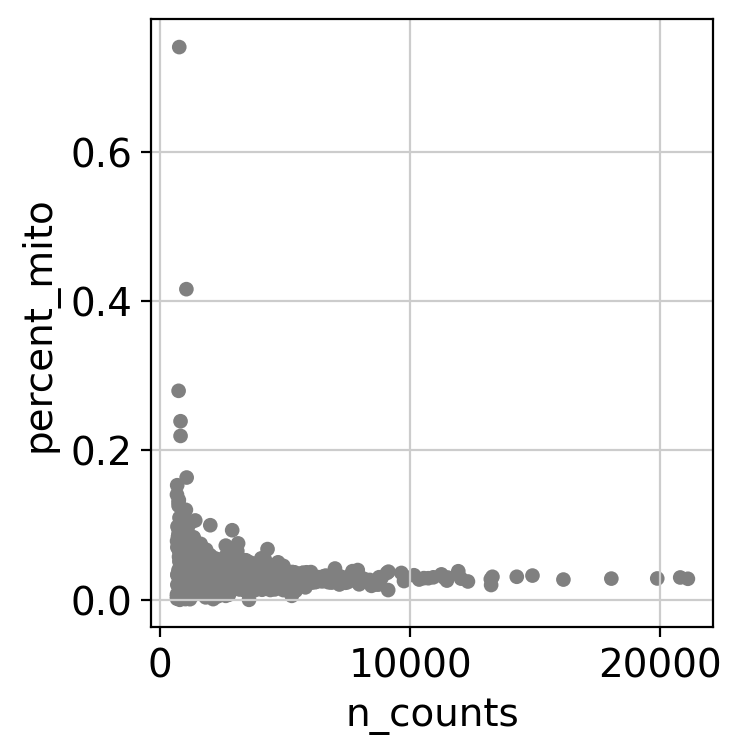

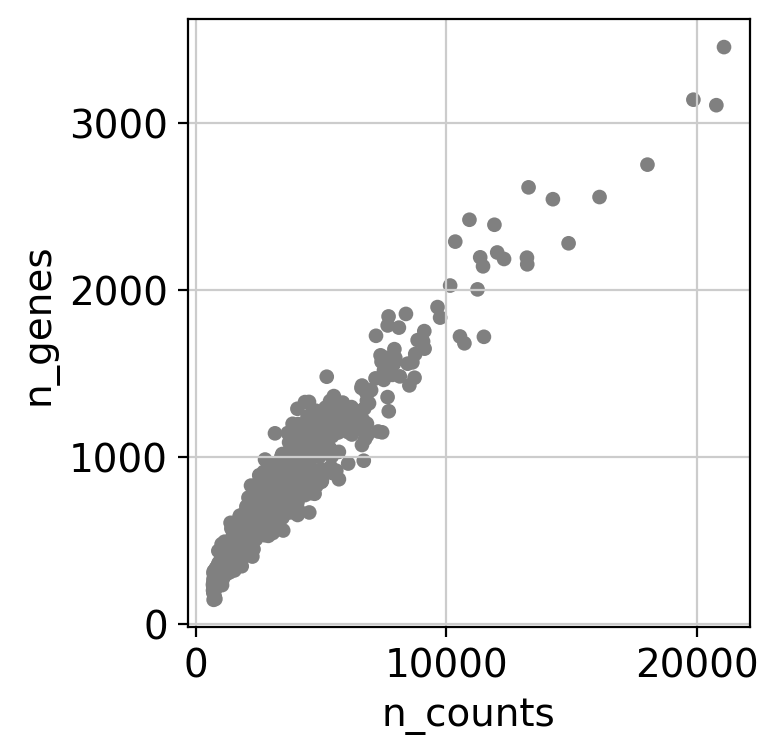

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170207_D00328_0611_AHFMGHBCXY_10x/P1
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


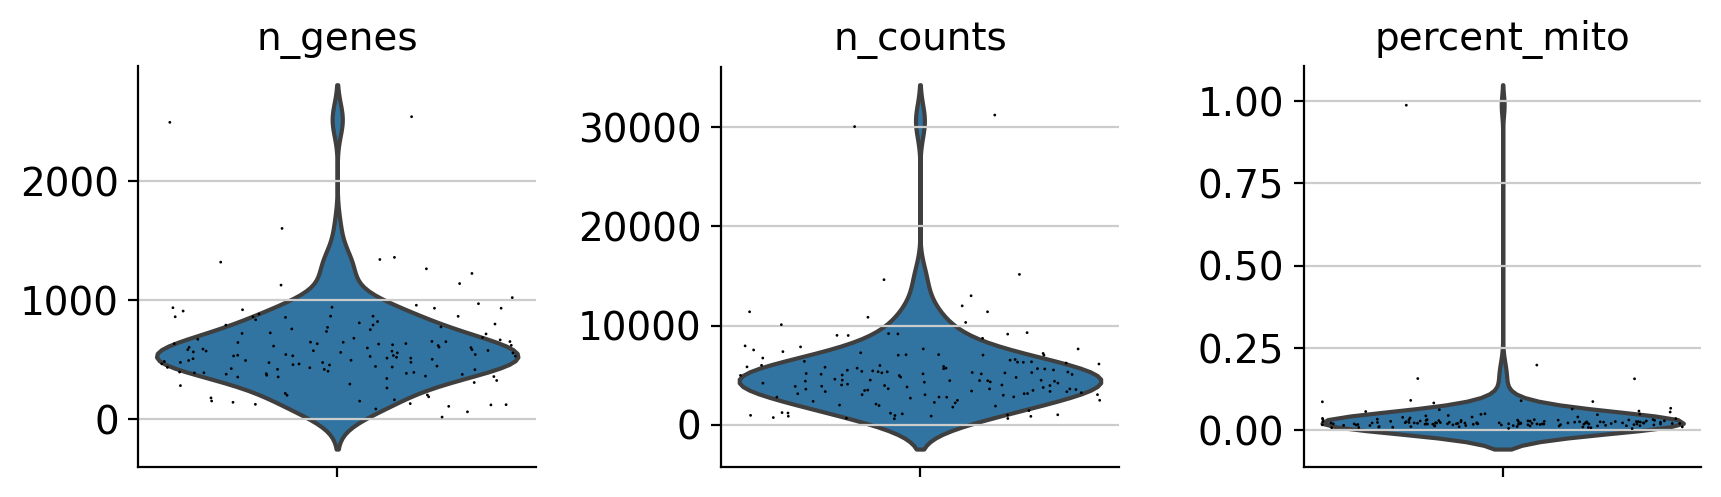

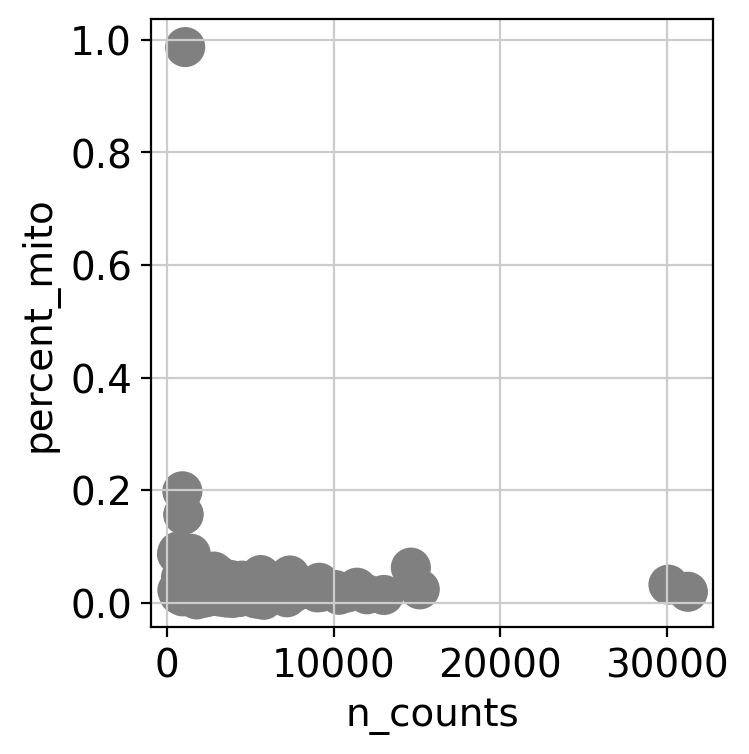

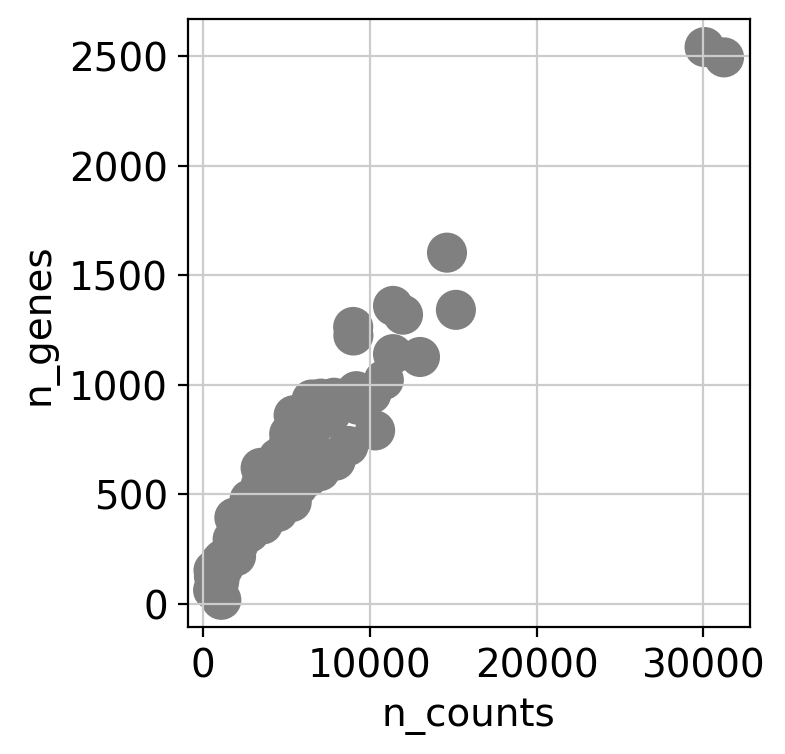

... storing 'patient' as categorical
... storing 'tissue' as categorical
... storing 'treatment' as categorical
... storing 'sample' as categorical
... storing 'comp' as categorical


170301_D00328_0619_AHFNFVBCXY_10xgenomics/SOC4N4
Annotating platelet contamination and Megakaryocytes.
Annotating RBCs


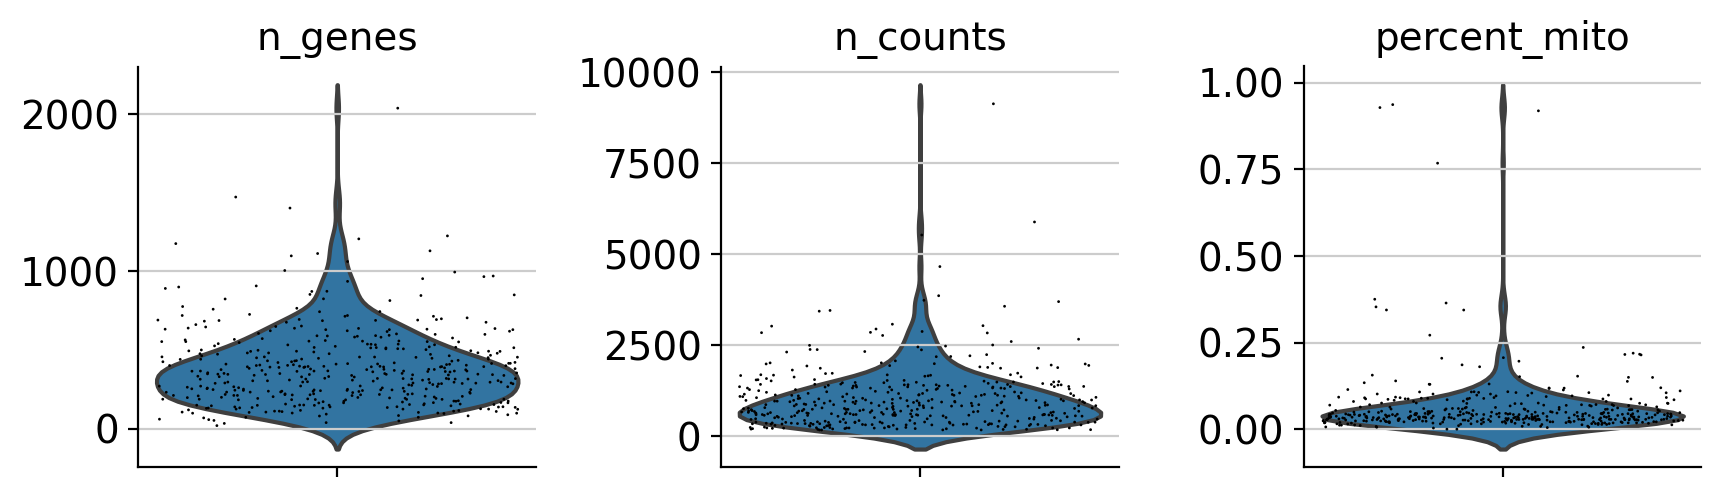

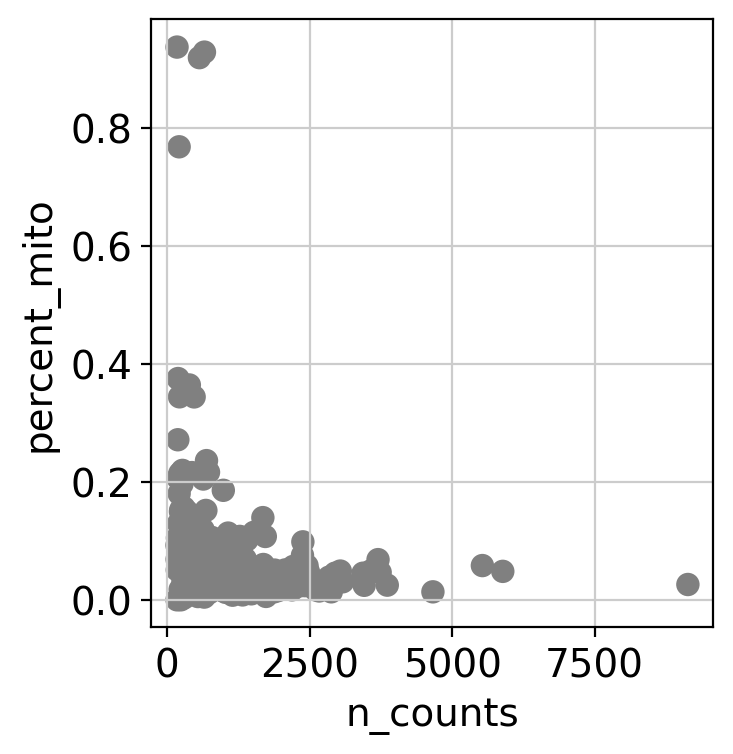

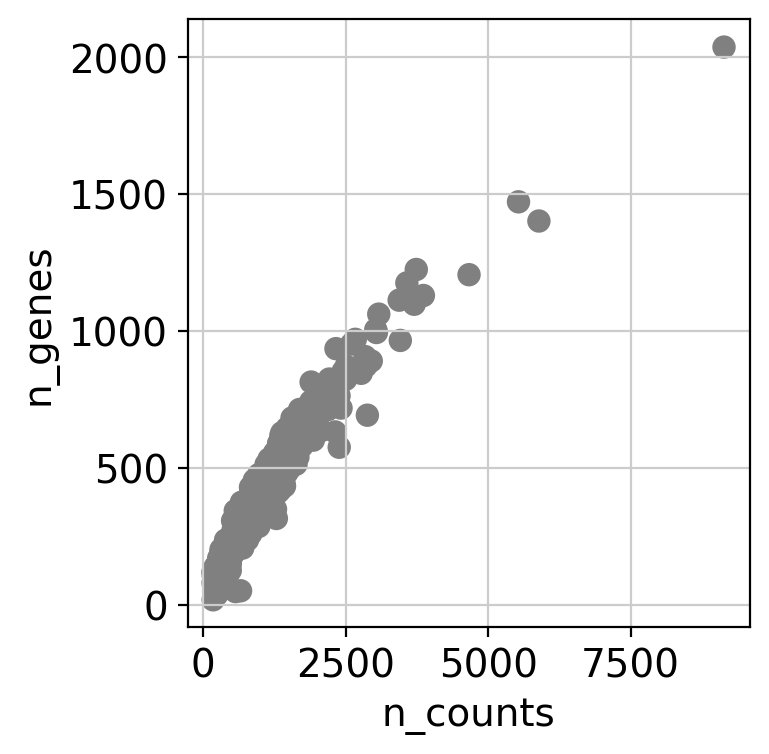

In [7]:
#Initialize dataframe to store cell counts
height = 4
width = no_wells

contamination_df = pd.DataFrame(0, index=range(height), columns=range(width))
contamination_df.rename(index={0:'Cells',1:'Platelets',2:'RBCs',3:'% cell with < 10% mito'}, inplace=True)
contamination_df.columns = RNA_files

for adata_index in range(len(RNA_adata)):
    adata = RNA_adata[adata_index]
    well = RNA_files[adata_index]
    print(well)
    #Remove platelets
    original_cell_no = adata.shape[0]
    
    print('Annotating platelet contamination and Megakaryocytes.')
    mat = csr_matrix(adata.X)
    mat = mat[:, adata.var_names.isin(['PF4'])].todense()

    platelets = adata[np.ravel(mat > 0)].obs.index
    no_platelets = len(platelets)
    
    platelet_info = [False] * original_cell_no
    
    index = 0
    
    for x in adata.obs.index:
        if x in platelets:
            platelet_info[index] = True
        index += 1
        
    adata.obs['platelet'] = platelet_info   
    print('Annotating RBCs')

    mat = csr_matrix(adata.X)
    mat = mat[:, adata.var_names.isin(['HBB'])].todense()
    
    RBCs = adata[np.ravel(mat > 1)].obs.index
    no_RBCs = len(RBCs)
    
    RBC_info = [False] * original_cell_no
    
    index = 0
    for x in adata.obs.index:
        if x in RBCs:
            RBC_info[index] = True
        index += 1

    adata.obs['RBC'] = RBC_info
    
    #Calculate quality metrics
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.obs['percent_mito'] = np.sum(
        adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
    #sc.pp.calculate_qc_metrics(adata, expr_type='counts', var_type='genes', percent_top=(50, 100, 200, 500), inplace=True)
    # for each cell compute fraction of counts in mito genes vs. all genes
    # the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

    # add the total counts per cell as observations-annotation to adata
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1
    adata.obs['n_genes'] = (adata.X !=0).sum(axis=1).A1
    sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                 jitter=0.4, multi_panel=True)
    sc.pl.scatter(adata, x='n_counts', y='percent_mito')
    cells_mito_cutoff = np.sum([adata.obs['percent_mito'] < 0.1])/original_cell_no
    sc.pl.scatter(adata, x='n_counts', y='n_genes')
    
    contamination_df[well] = [original_cell_no, no_platelets, no_RBCs, cells_mito_cutoff]
    RNA_adata[adata_index] = adata

In [8]:
#!mkdir /ye/yelabstore3/guy_mm/exp_002/analysis/pre_processing_002
cell_count_df.loc['Platelets'] = contamination_df.loc['Platelets']
cell_count_df.loc['RBCs'] = contamination_df.loc['RBCs']
cell_count_df.loc['% cell with < 10% mito'] = contamination_df.loc['% cell with < 10% mito']

#cell_count_df.to_csv('/wynton/scratch/EM/bladder_cancer/sample_cell_counts_exp_001.csv')
cell_count_df.columns = sample
cell_count_df.T

Cells  Platelets  RBCs  % cell with < 10% mito
atezo2    2399.0        0.0   3.0                0.989579
atezo3    2843.0        0.0   0.0                0.998241
atezo4    3695.0        0.0   1.0                0.996211
atezo5    3721.0        0.0   0.0                0.998925
soc1      1826.0        0.0   1.0                0.993428
soc2      3378.0        0.0   0.0                0.999112
soc3      1117.0        0.0   0.0                0.961504
a3normal   462.0        0.0   0.0                0.945887
a4normal   775.0        0.0   0.0                0.945806
a5normal   383.0        0.0   0.0                0.903394
s1normal  1077.0        0.0   0.0                0.985144
s2normal   144.0        0.0   0.0                0.972222
s3normal   422.0        0.0   0.0                0.881517

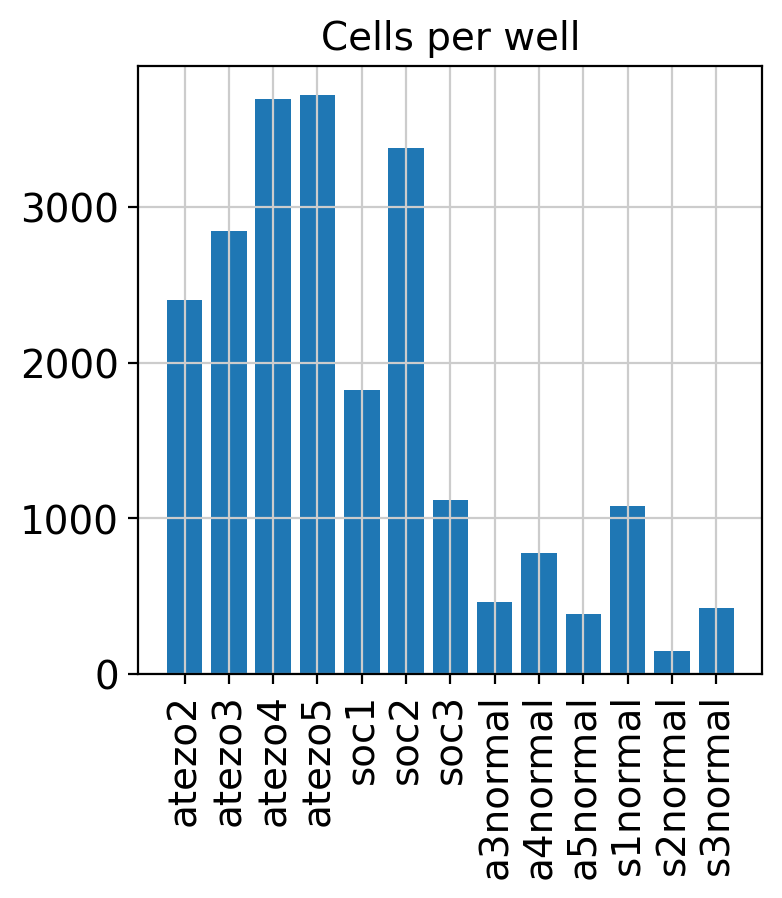

In [9]:
##Plot Cells
height = contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("Cells per well")
    
# Show graphic
plt.show()

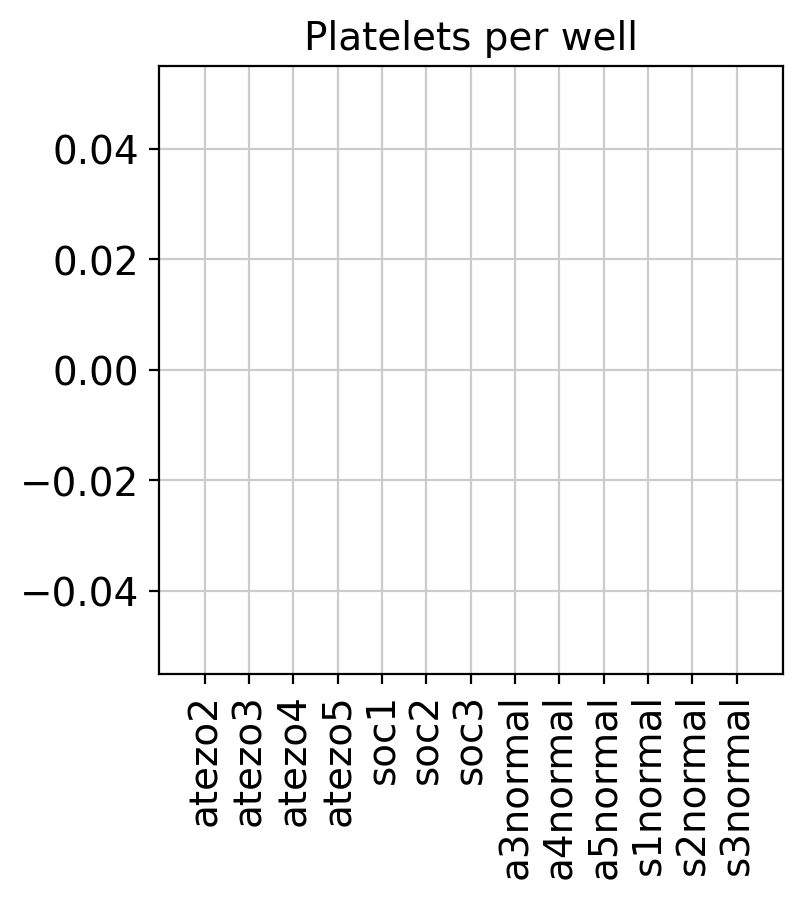

In [10]:
##Plot Platelets

height = contamination_df.iloc[1,:]/contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("Platelets per well")
    
# Show graphic
plt.show()


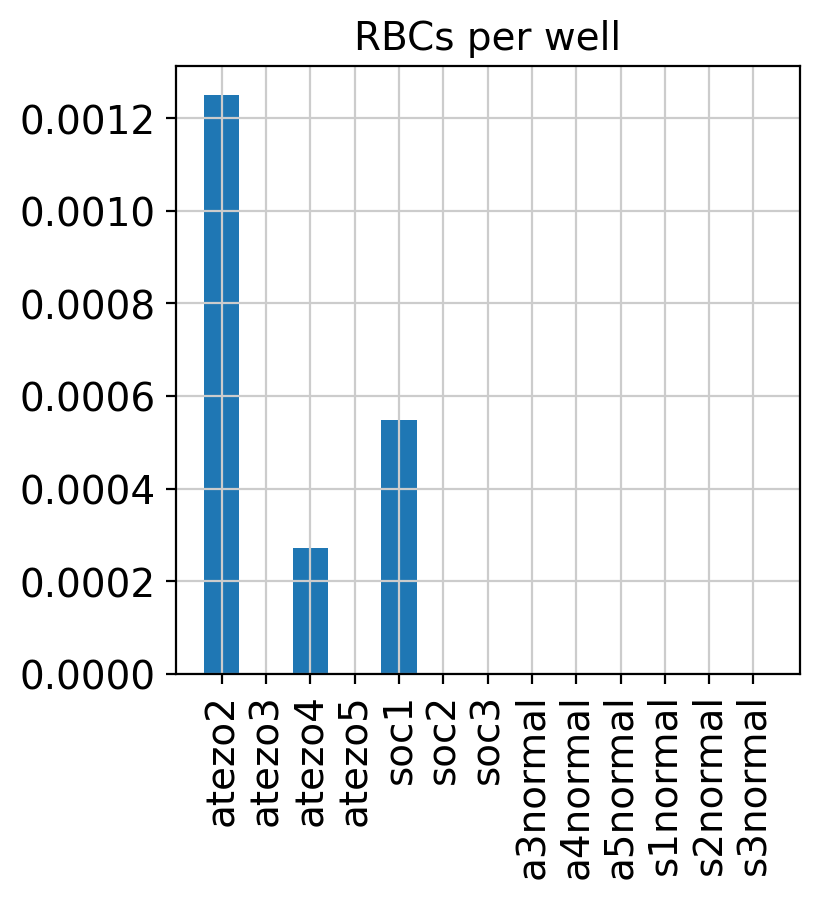

In [11]:
##Plot RBCs

height = contamination_df.iloc[2,:]/contamination_df.iloc[0,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("RBCs per well")
    
# Show graphic
plt.show()

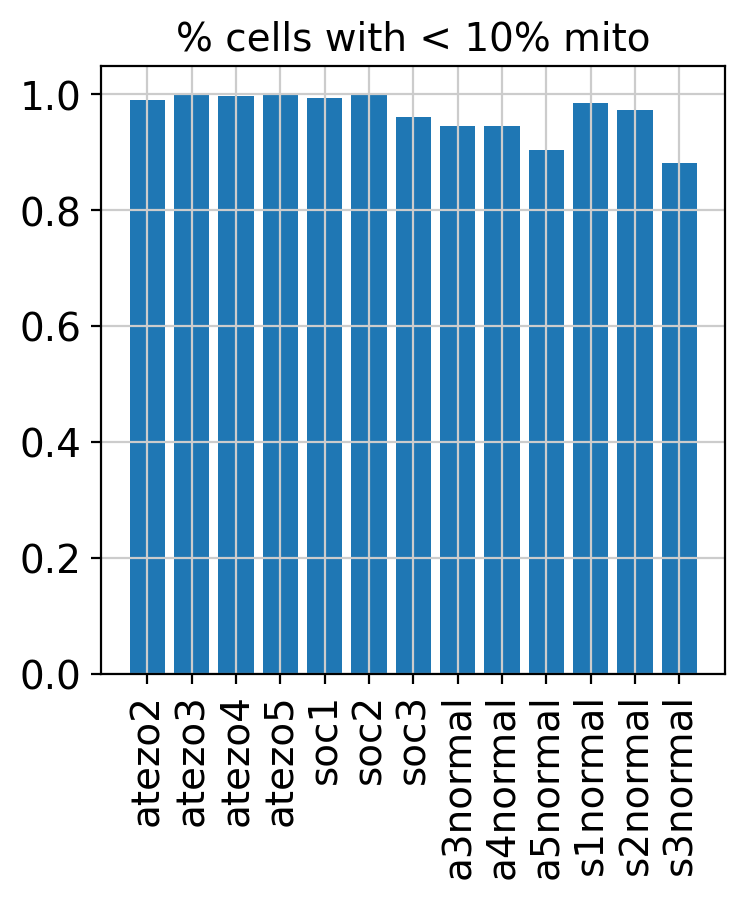

In [12]:
##Plot % mito
height = contamination_df.iloc[3,:]
bars = sample
y_pos = np.arange(len(bars))
 
# Create bars
plt.figure()
plt.bar(y_pos, height)
 
# Create names on the x-axis
plt.xticks(y_pos, bars, rotation='vertical')
plt.title("% cells with < 10% mito")
    
# Show graphic
plt.show()

In [13]:
path = '/wynton/group/fong/hyang7/bladder_blood_analysis/obj/preprocessing/'

adata_files = sample
adata_files = [x+"_CD4TILs" for x in adata_files]

adata_files = [path + x + '.h5ad' for x in adata_files]

for index in range(len(RNA_adata)):
    RNA_adata[index].write(adata_files[index])